In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
np.random.seed(42)

In [3]:
#store the path of the drug-metabolite file
gen_path = '/Users/neil/Downloads/NCI_genomics.xlsx'
path = '/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/Datasets/Gefitinib_integrated.csv'

In [4]:
#extract the name of the drug

dr = path.split('/')[-1]
drug_name = dr.split('_')[0]
drug_name

'Gefitinib'

In [5]:
#read the input drug-metabolite integrated data
data = pd.read_csv(path)

#read the input genomics data 
genomics = pd.read_excel(gen_path)

In [6]:
#drop the target drug column
drug = data.pop(f'{drug_name}')

In [7]:
#read the representative set of metabolites

with open('/Users/neil/Desktop/NCI Cell Lines/ModelRunNTimes/outputs/representative_metabolites.txt', 'r+') as f:
    rep_meta = f.read().strip().splitlines()
    
#read the genes

with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/list_of_genes.txt', 'r+') as f:
     rep_genes = f.read().strip().splitlines()   
     
rep_genes.extend(rep_meta)

In [8]:
len(rep_meta), len(rep_genes)

(197, 24023)

In [9]:
#select the input features, drop all metadata
X = data.select_dtypes('float64')

#select only the representative metabolites and the gene expression profiles
X = X[rep_genes]

#fill the NaNs with mean of each column
X.fillna(X.mean(), inplace=True)

In [10]:
X.shape

(52, 24023)

In [11]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

In [12]:
#create empty list to store labels and take mean of the response values
#if response value is greater than mean then store 'NR' else store 'R'
#convert the list of labels into a Series

target, drug_mean = [], drug.mean()
for i in drug:
    if i > drug_mean:
        target.append('NR')
    else:
        target.append('R')
y = pd.Series(target)

In [13]:
X.shape, y.shape

((52, 24023), (52,))

In [14]:
#initialize the LabelEncoder instance
le = LabelEncoder()

#encode the labels into 0 and 1 for NR and R respectively
y = pd.Series(le.fit_transform(y))
y.value_counts()

1    34
0    18
Name: count, dtype: int64

In [15]:
#initialize SMOTE instance
smote = SMOTE()

#use SMOTE to create synthetic samples to create a balanced set of data
X, y = smote.fit_resample(X, y)

In [16]:
#initialize StandardScaler for normalization of input features
scaler = StandardScaler()

#normalize the input dataframe
X = pd.DataFrame(data = scaler.fit_transform(X), columns = X.columns)
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.751759,1.058047,-0.004139,0.013280,-0.016797,-0.035006,-0.032688,-0.007088,2.049132,0.180323,...,-1.049101,-1.146296,-0.381610,-1.085401,0.924331,-1.135302,-0.386439,0.433083,-0.703154,0.996342
1,2.227184,0.228934,-0.236418,-0.251618,-0.016797,-0.258914,-0.032688,-0.007088,-0.973884,5.172570,...,-0.691917,-0.323451,-1.172167,-0.095182,-0.973381,-0.997389,-1.097757,-2.103144,-1.648259,0.628629


In [17]:
X.shape, y.shape

((68, 24023), (68,))

In [18]:
y.value_counts()

1    34
0    34
Name: count, dtype: int64

In [19]:
X.head(2)

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Theaflavin-3-gallate,"PC(14:0/18:4(6Z,9Z,12Z,15Z)) ; PC(14:1(9Z)/18:3(6Z,9Z,12Z)) ; PC(14:1(9Z)/18:3(9Z,12Z,15Z)) ; PC(18:3(6Z,9Z,12Z)/14:1(9Z)) ; PC(18:3(9Z,12Z,15Z)/14:1(9Z)) ; PC(18:4(6Z,9Z,12Z,15Z)/14:0) ; PE(15:0/20:4(5Z,8Z,11Z,14Z)) ; PE(15:0/20:4(8Z,11Z,14Z,17Z)) ; PE(20:4(5Z,8Z,11Z,14Z)/15:0) ; PE(20:4(8Z,11Z,14Z,17Z)/15:0)",Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8
0,4.751759,1.058047,-0.004139,0.013280,-0.016797,-0.035006,-0.032688,-0.007088,2.049132,0.180323,...,-1.049101,-1.146296,-0.381610,-1.085401,0.924331,-1.135302,-0.386439,0.433083,-0.703154,0.996342
1,2.227184,0.228934,-0.236418,-0.251618,-0.016797,-0.258914,-0.032688,-0.007088,-0.973884,5.172570,...,-0.691917,-0.323451,-1.172167,-0.095182,-0.973381,-0.997389,-1.097757,-2.103144,-1.648259,0.628629


In [20]:
#find the indices of the input dataset
indices = X.index.values

#split the dataset into train and test datasets
X_train, X_test, train_index, test_index = train_test_split(X, indices, test_size = 0.20, random_state = 43)
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [21]:
X_train.shape, X_test.shape

((54, 24023), (14, 24023))

In [22]:
y_train.value_counts(), y_test.value_counts()

(1    28
 0    26
 Name: count, dtype: int64,
 0    8
 1    6
 Name: count, dtype: int64)

In [23]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction = []

#define a list to store the number of features being selected each run
num_features = []

#define the model
model = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')

#define a list to store accuracy, precision and recall 
acc_score, rec_score, pre_score = [], [], []


#run the feature selection and model training and evaluation N times
for i in range(N): 
    #define base estimator for feature selection and fit the training data to it
    base_estimator = RandomForestClassifier(n_estimators = 150, class_weight = 'balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SelectFromModel to select features based on base estimator provided and use the mean of the feature importances
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train and test data using SFM
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X.columns[sfm.get_support(1)])
    
    print(f'Number of features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features.append(len(X_train.columns))
    
    #define the machine learning model and train it
    model.fit(X_train_new, y_train)
    
    #make predictions and other metrics
    y_pred = model.predict(X_test_new)
    acc_score.append(accuracy_score(y_test, y_pred))
    rec_score.append(recall_score(y_test, y_pred, pos_label=1))
    pre_score.append(precision_score(y_test, y_pred, pos_label=1))
    
    #store the probabilites of each run
    prediction.append(model.predict_proba(X_test_new))

    
acc_score = np.array(acc_score)
rec_score = np.array(rec_score)
pre_score = np.array(pre_score)
print(f'Accuracy score: {np.mean(acc_score)}, Standard deviation: {np.std(acc_score)}')
print(f'Recall score: {np.mean(rec_score)}, Standard deviation: {np.std(rec_score)}')
print(f'Precision score: {np.mean(pre_score)}, Standard deviation: {np.std(pre_score)}')

#indice = np.unique(np.array(indice))
prediction = np.array(prediction)
prediction = np.mean(prediction, axis=0)[:, 1]

Number of features selected during iteration 0: 576
Number of features selected during iteration 1: 551
Number of features selected during iteration 2: 587
Number of features selected during iteration 3: 557
Number of features selected during iteration 4: 559
Number of features selected during iteration 5: 566
Number of features selected during iteration 6: 567
Number of features selected during iteration 7: 573
Number of features selected during iteration 8: 574
Number of features selected during iteration 9: 558
Number of features selected during iteration 10: 573
Number of features selected during iteration 11: 557
Number of features selected during iteration 12: 576
Number of features selected during iteration 13: 560
Number of features selected during iteration 14: 579
Number of features selected during iteration 15: 603
Number of features selected during iteration 16: 566
Number of features selected during iteration 17: 574
Number of features selected during iteration 18: 578
Num

In [24]:
features = list(X_train_new.columns)
count = 0
for i in features:
    if i in rep_meta:
        count+=1 #get the number of metabolites selected from the represented features
count, len(features) - count #count the number of genes 

(7, 573)

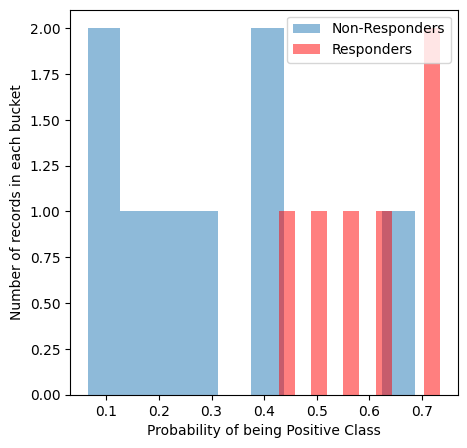

In [25]:
plt.figure(figsize=(5, 5))
plt.hist(prediction[y_test==0], label='Non-Responders', alpha = 0.5)
plt.hist(prediction[y_test==1], label='Responders', alpha=0.5, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [26]:
df_rf_test = X_test.copy()
df_rf_test.loc[test_index, 'test_proba'] = prediction
df_rf_test.loc[test_index, 'target'] = y
df1 = pd.concat([X_train, df_rf_test], sort=False).sort_index()

In [27]:
df1

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.751759,1.058047,-0.004139,0.013280,-0.016797,-0.035006,-0.032688,-0.007088,2.049132,0.180323,...,-0.381610,-1.085401,0.924331,-1.135302,-0.386439,0.433083,-0.703154,0.996342,NaN,NaN
1,2.227184,0.228934,-0.236418,-0.251618,-0.016797,-0.258914,-0.032688,-0.007088,-0.973884,5.172570,...,-1.172167,-0.095182,-0.973381,-0.997389,-1.097757,-2.103144,-1.648259,0.628629,NaN,NaN
2,-0.533217,-0.925913,-0.332213,-0.252547,-0.016797,-0.409457,-0.032688,-0.609918,-1.054985,0.180323,...,0.093465,-0.965668,-0.125344,-1.022848,-0.240555,-0.463425,-0.580062,-0.313827,NaN,NaN
3,2.568808,0.759700,-0.355888,-0.253152,-0.510762,-0.035006,-0.032688,-0.414965,-0.764773,0.180323,...,-0.091436,-0.347687,0.394153,0.270202,-0.333463,-0.748801,0.665035,-0.892810,NaN,NaN
4,1.625977,-0.868195,-0.004139,-0.251049,-0.016797,-0.035006,-0.032688,-0.320052,-0.986571,0.017055,...,-1.267523,0.119915,-1.754844,1.176401,-2.048980,-0.581053,-1.134918,-0.166545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.253454,-0.064342,-0.201339,-0.130238,0.277522,-0.035006,-0.032688,-0.313324,-0.298796,0.180323,...,0.144373,0.168982,0.146800,-1.601462,-1.449980,-0.073447,0.392459,-0.605140,NaN,NaN
64,0.358404,0.976711,-0.098575,-0.198221,0.137596,-0.221060,1.636955,-0.199035,-0.438082,-0.494121,...,0.177882,-0.932105,-0.072840,-0.655149,0.490158,0.323356,-0.119071,-0.228626,NaN,NaN
65,0.283983,0.343003,-0.004977,-0.042455,0.112943,-0.065752,-0.032688,1.393514,-0.598436,0.168257,...,1.476720,0.481193,0.520099,-0.432132,-0.737582,1.450805,1.202554,-0.158604,NaN,NaN
66,-0.433236,-0.492116,-0.253216,-0.221049,0.354947,-0.035006,-0.032688,-0.499787,0.154631,0.180323,...,-0.863262,0.607222,-0.206584,-1.921010,-1.560195,-1.205038,-0.548906,-0.477658,0.303467,0.0


In [28]:
df1_main = df1.iloc[:51, ]
x = max(prediction[y_test == 0])
df1_main = df1_main.loc[(df1_main['test_proba'] > x)]
df1_main.shape

(2, 24025)

In [29]:
df1_main.index.values #0 40 41 42

array([5, 6])

In [30]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction2 = []

#define a list to store the number of features selected in each iteration
num_features2 = []

#define a list to store accuracy, precision and recall 
model2 = SVC(C=1, gamma=1, probability=True)
acc_score2, rec_score2, pre_score2 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define the base estimator for feature selection
    base_estimator = RandomForestClassifier(n_estimators=150, class_weight='balanced')
    base_estimator.fit(X_train, y_train)
    
    #compute the importances of each feature
    importances = base_estimator.feature_importances_
    
    #use SelectFromModel and mean importances to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform the train-test data using important features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_train.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features2.append(len(X_train_new.columns))

    #define the SVM model and train it
    model2.fit(X_train_new, y_train)
    
    #comput predictions
    y_pred2 = model2.predict(X_test_new)
    acc_score2.append(accuracy_score(y_test, y_pred2))
    rec_score2.append(recall_score(y_test, y_pred2, pos_label=1))
    pre_score2.append(precision_score(y_test, y_pred2, pos_label=1))
    prediction2.append(model2.predict_proba(X_test_new))


acc_score2 = np.array(acc_score2)
rec_score2 = np.array(rec_score2)
pre_score2 = np.array(pre_score2)
print(f'Accuracy score: {np.mean(acc_score2)}, Standard deviation: {np.std(acc_score2)}')
print(f'Recall score: {np.mean(rec_score2)}, Standard deviation: {np.std(rec_score2)}')
print(f'Precision score: {np.mean(pre_score2)}, Standard deviation: {np.std(pre_score2)}')


prediction2 = np.array(prediction2)
prediction2 = np.mean(prediction2, axis=0)[:, 1]

Features selected during iteration 0: 567
Features selected during iteration 1: 582
Features selected during iteration 2: 574
Features selected during iteration 3: 566
Features selected during iteration 4: 558
Features selected during iteration 5: 589
Features selected during iteration 6: 569
Features selected during iteration 7: 578
Features selected during iteration 8: 554
Features selected during iteration 9: 571
Features selected during iteration 10: 579
Features selected during iteration 11: 562
Features selected during iteration 12: 573
Features selected during iteration 13: 563
Features selected during iteration 14: 571
Features selected during iteration 15: 564
Features selected during iteration 16: 556
Features selected during iteration 17: 555
Features selected during iteration 18: 583
Features selected during iteration 19: 571
Features selected during iteration 20: 561
Features selected during iteration 21: 576
Features selected during iteration 22: 577
Features selected dur

In [31]:
print(f'Average number of features being selected: {np.mean(num_features2)}')

Average number of features being selected: 570.28


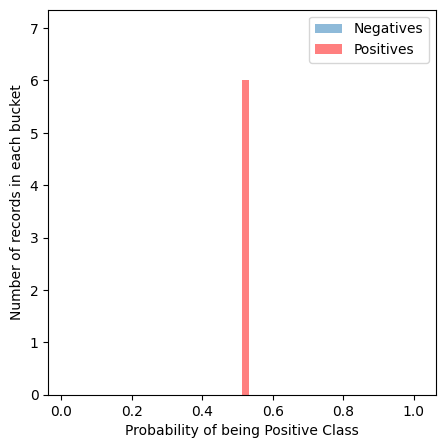

In [32]:
plt.figure(figsize=(5,5))
plt.hist(prediction2[y_test==0], label='Negatives', alpha = 0.5, bins = 50)
plt.hist(prediction2[y_test==1], label='Positives', alpha=0.5, bins = 50, color = 'r')
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [33]:
df_svm_test = X_test.copy()
df_svm_test.loc[test_index, 'test_proba'] = prediction2
df_svm_test.loc[test_index, 'target'] = y_test
df2 = pd.concat([X_train, df_svm_test], sort=False).sort_index()

In [34]:
df2_main = df2.iloc[:51, ]
df2_main = df2_main.loc[(df2_main['test_proba'] > max(prediction2[y_test == 0]))]
df2_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target


In [35]:
df2_main.index.values #40 41 42

array([], dtype=int64)

In [36]:
#define the number of iterations for model training and testing
N = 50

#define a list to store the probabilities
prediction3 = []

#define a list to store the number of features being selected in each iteration
num_features3 = []

#define the XGBoost model
model3 = XGBClassifier()

#define a list to store accuracy, precision and recall 
acc_score3, rec_score3, pre_score3 = [], [], []

#run a for loop N times and store the prediction probabilities of each run
for i in range(N):
    #define base estimator to compute feature importances
    base_estimator = XGBClassifier()
    base_estimator.fit(X_train, y_train)
    
    #compute feature importances
    importances = base_estimator.feature_importances_
    
    #define SFM model to select important features
    sfm = SelectFromModel(base_estimator, threshold = importances.mean())
    sfm.fit(X_train, y_train)
    
    #transform train and test sets using best features
    X_train_new = pd.DataFrame(data = sfm.transform(X_train), columns = X_train.columns[sfm.get_support(1)])
    X_test_new = pd.DataFrame(data = sfm.transform(X_test), columns = X_test.columns[sfm.get_support(1)])
    
    print(f'Features selected during iteration {i}: {len(X_train_new.columns)}')
    num_features3.append(len(X_train_new.columns))

    #define XGBoost model and train it
    model3.fit(X_train_new, y_train)
    
    #compute predictions
    y_pred3 = model3.predict(X_test_new)
    acc_score3.append(accuracy_score(y_test, y_pred3))
    rec_score3.append(recall_score(y_test, y_pred3, pos_label=1))
    pre_score3.append(precision_score(y_test, y_pred3, pos_label=1))
    prediction3.append(model3.predict_proba(X_test_new))


acc_score3 = np.array(acc_score3)
rec_score3 = np.array(rec_score3)
pre_score3 = np.array(pre_score3)
print(f'Accuracy score: {np.mean(acc_score3)}, Standard deviation: {np.std(acc_score3)}')
print(f'Recall score: {np.mean(rec_score3)}, Standard deviation: {np.std(rec_score3)}')
print(f'Precision score: {np.mean(pre_score3)}, Standard deviation: {np.std(pre_score3)}')


prediction3 = np.array(prediction3)
prediction3 = np.mean(prediction3, axis=0)[:, 1]

Features selected during iteration 0: 28
Features selected during iteration 1: 28
Features selected during iteration 2: 28
Features selected during iteration 3: 28
Features selected during iteration 4: 28
Features selected during iteration 5: 28
Features selected during iteration 6: 28
Features selected during iteration 7: 28
Features selected during iteration 8: 28
Features selected during iteration 9: 28
Features selected during iteration 10: 28
Features selected during iteration 11: 28
Features selected during iteration 12: 28
Features selected during iteration 13: 28
Features selected during iteration 14: 28
Features selected during iteration 15: 28
Features selected during iteration 16: 28
Features selected during iteration 17: 28
Features selected during iteration 18: 28
Features selected during iteration 19: 28
Features selected during iteration 20: 28
Features selected during iteration 21: 28
Features selected during iteration 22: 28
Features selected during iteration 23: 28
Fe

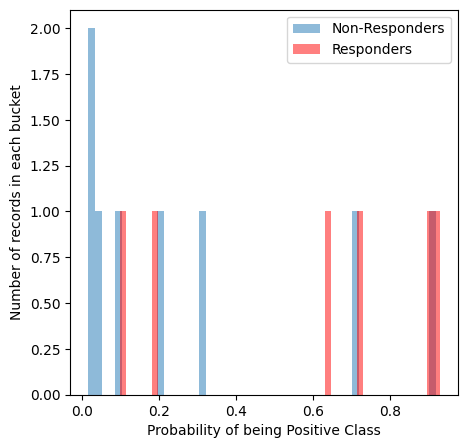

In [37]:
plt.figure(figsize=(5, 5))
plt.hist(prediction3[y_test==0], label='Non-Responders', bins = 50, alpha = 0.5)
plt.hist(prediction3[y_test==1], label='Responders', alpha=0.5, color='r', bins = 50)
plt.xlabel('Probability of being Positive Class')
plt.ylabel('Number of records in each bucket')
plt.legend()
plt.tick_params(axis='both')
plt.show() 

In [38]:
df_xg = X_test.copy()
df_xg.loc[test_index, 'test_proba'] = prediction3
df_xg.loc[test_index, 'target'] = y_test
df3 = pd.concat([X_train, df_xg], sort=False).sort_index()
df3

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
0,4.751759,1.058047,-0.004139,0.013280,-0.016797,-0.035006,-0.032688,-0.007088,2.049132,0.180323,...,-0.381610,-1.085401,0.924331,-1.135302,-0.386439,0.433083,-0.703154,0.996342,NaN,NaN
1,2.227184,0.228934,-0.236418,-0.251618,-0.016797,-0.258914,-0.032688,-0.007088,-0.973884,5.172570,...,-1.172167,-0.095182,-0.973381,-0.997389,-1.097757,-2.103144,-1.648259,0.628629,NaN,NaN
2,-0.533217,-0.925913,-0.332213,-0.252547,-0.016797,-0.409457,-0.032688,-0.609918,-1.054985,0.180323,...,0.093465,-0.965668,-0.125344,-1.022848,-0.240555,-0.463425,-0.580062,-0.313827,NaN,NaN
3,2.568808,0.759700,-0.355888,-0.253152,-0.510762,-0.035006,-0.032688,-0.414965,-0.764773,0.180323,...,-0.091436,-0.347687,0.394153,0.270202,-0.333463,-0.748801,0.665035,-0.892810,NaN,NaN
4,1.625977,-0.868195,-0.004139,-0.251049,-0.016797,-0.035006,-0.032688,-0.320052,-0.986571,0.017055,...,-1.267523,0.119915,-1.754844,1.176401,-2.048980,-0.581053,-1.134918,-0.166545,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,-0.253454,-0.064342,-0.201339,-0.130238,0.277522,-0.035006,-0.032688,-0.313324,-0.298796,0.180323,...,0.144373,0.168982,0.146800,-1.601462,-1.449980,-0.073447,0.392459,-0.605140,NaN,NaN
64,0.358404,0.976711,-0.098575,-0.198221,0.137596,-0.221060,1.636955,-0.199035,-0.438082,-0.494121,...,0.177882,-0.932105,-0.072840,-0.655149,0.490158,0.323356,-0.119071,-0.228626,NaN,NaN
65,0.283983,0.343003,-0.004977,-0.042455,0.112943,-0.065752,-0.032688,1.393514,-0.598436,0.168257,...,1.476720,0.481193,0.520099,-0.432132,-0.737582,1.450805,1.202554,-0.158604,NaN,NaN
66,-0.433236,-0.492116,-0.253216,-0.221049,0.354947,-0.035006,-0.032688,-0.499787,0.154631,0.180323,...,-0.863262,0.607222,-0.206584,-1.921010,-1.560195,-1.205038,-0.548906,-0.477658,0.32057,0.0


In [39]:
df3_main = df3.iloc[:51, ]
df3_main = df3_main.loc[(df3_main['test_proba'] > max(prediction3[y_test == 0]))]
df3_main

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,1.037377,1.242935,-0.337963,-0.25274,-0.016797,-0.035006,-0.032688,-0.596694,-0.942695,0.180323,...,-0.403301,0.319055,0.095689,0.734176,-1.398287,1.219027,0.704792,-1.150351,0.930218,1.0


In [40]:
common_list = []
common_list.extend(list(df1_main.index.values))
common_list.extend(list(df2_main.index.values))
common_list.extend(list(df3_main.index.values))

In [41]:
cl = set(common_list)
cl

{5, 6}

In [42]:
df1_total = df1.loc[:51, ]
df1_total = df1_total.loc[(df1_total['target'] == 1.0)]
df1_total

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,Hexacarboxylporphyrin I ; Hexacarboxylporphyrin III ; Porphinehexacarboxylic acid,beta-casomorphin (1-6),"TG(16:0/14:0/18:2(9Z,12Z))_iso6_ ; TG(16:0/16:1(9Z)/16:1(9Z))_iso3_ ; TG(16:1(9Z)/14:0/18:1(11Z))_iso6_ ; TG(16:1(9Z)/14:0/18:1(9Z))_iso6_",Heme O,neuromedin B (4-10),Hydroxymethylbilane,Sennoside B,dynorphin A 1-8,test_proba,target
5,1.037377,1.242935,-0.337963,-0.252740,-0.016797,-0.035006,-0.032688,-0.596694,-0.942695,0.180323,...,-0.403301,0.319055,0.095689,0.734176,-1.398287,1.219027,0.704792,-1.150351,0.733867,1.0
6,0.727932,0.852695,-0.345071,-0.238979,-0.096984,-0.035006,-0.032688,-0.570856,-0.716285,0.180323,...,-0.586673,-0.864915,-0.392632,0.270821,0.196031,-0.775205,-0.401844,1.627418,0.707733,1.0
13,-0.707516,-0.944193,-0.004139,-0.252385,-0.379452,-0.035006,-0.032688,-0.007088,-0.993340,0.180323,...,0.812254,0.712285,0.213337,-0.014349,1.448565,0.113589,0.476339,-0.986092,0.570533,1.0
22,-0.446479,-0.418949,-0.004139,-0.215135,0.030264,-0.035006,-0.032688,-0.007088,-0.421570,0.180323,...,-1.537244,1.498768,-1.142845,1.245682,-0.708996,-1.158321,-1.867181,-0.708244,0.428000,1.0
26,-0.873687,0.080421,-0.276396,0.013280,-0.016797,-0.035006,-0.032688,-0.007088,-0.198427,0.180323,...,2.443060,1.454468,0.842091,0.352178,1.547950,1.128010,2.051738,-0.679959,0.622400,1.0
44,-0.732748,0.080421,-0.314102,-0.251509,-0.016797,-0.416101,-0.032688,-0.007088,0.584172,0.180323,...,-0.569947,-0.304279,-0.692510,-0.556536,-0.700862,0.120247,-0.332231,0.138919,0.506800,1.0


In [43]:
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/master_list_metabolomics.txt', 'a+') as f:
    for i in cl:
        f.write(f'{i}\n')

In [44]:
l = []
l.extend(df1_total.index.values)
with open('/Users/neil/Desktop/NCI Cell Lines/Integrated Analysis with Rep Meta/outputs/total_metabolomics.txt', 'a+') as f:
    for i in l:
        f.write(f'{i}\n')